In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

train_MNIST = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_MNIST = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

train_USPS = datasets.USPS('USPS', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_USPS = datasets.USPS('USPS', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

trainset_MNIST = torch.utils.data.DataLoader(train_MNIST, batch_size=32, shuffle=True)
testset_MNIST = torch.utils.data.DataLoader(test_MNIST, batch_size=32, shuffle=False)

trainset_USPS = torch.utils.data.DataLoader(train_USPS, batch_size=32, shuffle=True)
testset_USPS = torch.utils.data.DataLoader(test_USPS, batch_size=32, shuffle=False)

In [2]:
# defining the transformation

p = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor(),
])

In [3]:
# transforming the MNIST data according to how it is done in the paper. First interpolating so that images are 32x32 and than performing 'random' 28x28 crop

train_MNIST_transformed = [] # initializing the entire (batched) dataset as an empty list

for batch_MNIST in trainset_MNIST:
        
    images = batch_MNIST[0] # taking the images from the dataset batch. this a torch.tensor of shape (32, 1, 28, 28)
    labels = batch_MNIST[1] # taking the labels from the dataset batch. 
    
    images_transformed = torch.zeros(size=torch.Size([32, 1, 28, 28])) # initializing the transformed images with the same shape as images (32, 1, 28, 28)
        
    for i in range(0, len(images)):
        
        image = images[i] 
        
        image_transformed = p(image) # transforming the image with predefined transformation "p"
        images_transformed[i] = image_transformed # replacing zero tensor (1, 28, 28) in images_transformed with the transformed image
            
    batch_MNIST_transformed = [images_transformed, labels] # transformed batch is simply a list of batch of images in [0] and batch of labels in [1]
    
    train_MNIST_transformed.append(batch_MNIST_transformed) # appending to the empty dataset list

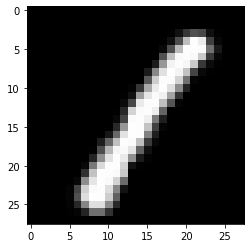

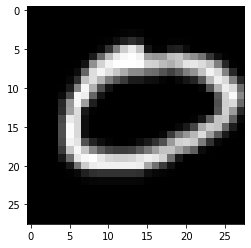

In [5]:
# plotting 2 images from MNIST datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_MNIST_0 = train_MNIST_transformed[0]
images0 = batch_MNIST_0[0]
image0 = images0[0]
image1 = images0[1]

plt.imshow(image0.view(28,28), cmap="gray")
plt.show()

plt.imshow(image1.view(28,28), cmap="gray")
plt.show()

In [6]:
# transforming the USPS data according to how it is done in the paper. First interpolating so that images are 32x32 and than performing 'random' 28x28 crop

train_USPS_transformed = [] # initializing the entire (batched) dataset as an empty list

for batch_USPS in trainset_USPS:
        
    images = batch_USPS[0] # taking the images from the dataset batch. this a torch.tensor of shape (32, 1, 28, 28)
    labels = batch_USPS[1] # taking the labels from the dataset batch. 
    
    images_transformed = torch.zeros(size=torch.Size([32, 1, 28, 28])) # initializing the transformed images with the same shape as images (32, 1, 28, 28)
        
    for i in range(0, len(images)):
        
        image = images[i] 
        
        image_transformed = p(image) # transforming the image with predefined transformation "p"
        images_transformed[i] = image_transformed # replacing zero tensor (1, 28, 28) in images_transformed with the transformed image
            
    batch_USPS_transformed = [images_transformed, labels] # transformed batch is simply a list of batch of images in [0] and batch of labels in [1]
    
    train_USPS_transformed.append(batch_USPS_transformed) # appending to the empty dataset list

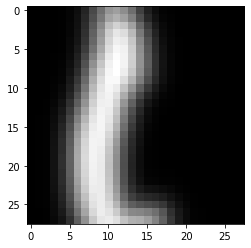

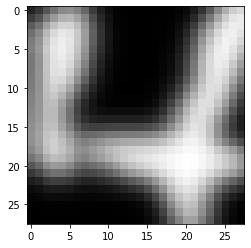

In [8]:
# plotting 2 images from USPS datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_USPS_0 = train_USPS_transformed[0]

images0 = batch_USPS_0[0]
image0 = images0[0]
image1 = images0[1]

plt.imshow(image0.view(28,28), cmap="gray")
plt.show()

plt.imshow(image1.view(28,28), cmap="gray")
plt.show()

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [81]:
class fNet(nn.Module):
    def __init__(self):
        super(fNet, self).__init__()
        
#             # 1st conv layer
#             # input [1 x 28 x 28]
#             # output [64 x 12 x 12]

#             # 2nd conv layer
#             # input [64 x 12 x 12]
#             # output [64 x 4 x 4]

#             # 3rd conv layer
#             # input [64 x 4 x 4]
#             # output [128 x 1 x 1]

        self.conv1 = nn.Conv2d(1, 64, 5) 
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
#         self.fc1 = nn.Linear(128 * 1 * 1, 512)

        self.pool = nn.MaxPool2d(2, 2, padding=1)
         
    def forward(self, x):
        output = self.pool(F.relu(self.conv1(x)))
        output = self.pool(F.relu(self.conv2(output)))
        output = F.relu(self.conv3(output))
        output = output.view(-1, 128 * 1 * 1)
#         output = self.fc1(output)
        return output

In [103]:
# just trying to pass some data to see if it works

fnet = fNet()
print(fnet)

output_f = fnet(batch_MNIST_0[0])
print(output.shape)

fNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
)
torch.Size([32, 128])


In [92]:
class gNet(nn.Module):
    def __init__(self):
        super(gNet, self).__init__()
                
#             # 1st conv layer
#             # input [1 x 28 x 28]
#             # output [64 x 12 x 12]

#             # 2nd conv layer
#             # input [64 x 12 x 12]
#             # output [64 x 4 x 4]

#             # 3rd conv layer
#             # input [64 x 4 x 4]
#             # output [128 x 1 x 1]

        self.conv1 = nn.Conv2d(1, 64, 5) 
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
#         self.fc1 = nn.Linear(128 * 1 * 1, 512)

        self.pool = nn.MaxPool2d(2, 2, padding=1)
         
    def forward(self, x):
        output = self.pool(F.relu(self.conv1(x)))
        output = self.pool(F.relu(self.conv2(output)))
        output = F.relu(self.conv3(output))
        output = output.view(-1, 128 * 1 *1)
#         output = self.fc1(output)
        return output

In [104]:
# again trying to pass some data to check if the gNet works

gnet = gNet()
print(gnet)
print(batch_USPS_0[0].shape)
output_g = gnet(batch_USPS_0[0])
print(output_g.shape)

gNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
)
torch.Size([32, 1, 28, 28])
torch.Size([32, 128])


In [96]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.restored = True

        
        self.layer = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        
        output = self.layer(x)
        return output

In [10]:
def init_weights_disc(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight)
#         m.bias.data.fill_(0.01)

In [11]:
disc = Discriminator()
disc.apply(init_weights_disc)
print(disc)

disc_output = disc(output)
print(disc_output)

NameError: name 'Discriminator' is not defined

In [147]:
class hSim(nn.Module):
    def __init__(self):
        super().__init__()
    

        self.restored = True
        
        self.U = torch.rand(size=(128, 512), requires_grad=True)
        self.V = torch.rand(size=(128, 512), requires_grad=True)
        
    def forward(self, x_batch, mu_c_batch):
        
        h_batch = torch.zeros(size=[32]) # batchsize = 32

        for i in range(0, len(x_batch)):
            x = x_batch[i]
            mu_c = mu_c_batch[i]

            
            fac1 = torch.matmul(x, self.U)
            fac2 = torch.matmul(mu_c, self.V)
        
            h = torch.matmul(fac1, fac2)
            h_batch[i] = F.softmax(h, dim=0)
        
        return h_batch    

In [148]:
hsim = hSim()

# print(output_f.shape)
output_h = hsim(output_f, output_g)
print(output_h)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<CopySlices>)


In [95]:
# try stuff cell

t = torch.tensor([[1,2],[2,1]])
print(t.shape)
t = torch.flatten(t)
print(t.shape)
print(t)

torch.Size([2, 2])
torch.Size([4])
tensor([1, 2, 2, 1])
